# MLFLOW

MLFlow is an open-source ML platform for tracking, packaging, and deploying models.

In [41]:
import os
import joblib
import tempfile
import pandas as pd 
import mlflow
from argparse import Namespace
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
import matplotlib.pyplot as plt
df = pd.read_csv('train.csv') # House price dataset (regression)

# Set Tracking URI
- Tracking in MLFlow is an API that enables you to log model params, metrics and the models themselves - along with other metrics. 


In [2]:
MODEL_REG=Path('experiments')
Path(MODEL_REG).mkdir(exist_ok=True) # Create experiments dir
mlflow.set_tracking_uri('file:///' + str(MODEL_REG.absolute()))

**Train Model**

In [3]:
m = LinearRegression()
cols=df.select_dtypes(['int','float']).columns
X = df[cols].fillna(df[cols].mean())
X_train,X_test,y_train,y_test=train_test_split(X.drop(columns='SalePrice'), X['SalePrice'], random_state=0)
m.fit(X_train,y_train)
preds=m.predict(X_test)

# Set Experiment

In [8]:
mlflow.set_experiment(experiment_name='housing')

2022/09/19 15:02:11 INFO mlflow.tracking.fluent: Experiment with name 'housing' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:\\Users\\crysi\\Documents\\GitHub\\Data-Science\\ML-Ops\\experiments/1', experiment_id='1', lifecycle_stage='active', name='housing', tags={}>

**Helpers**

In [6]:
 
def pred_error(X_train,X_test,y_train,y_test):
    fig, axs=plt.subplots(1,figsize=(10,10))
    pe = PredictionError(LinearRegression())
    pe.fit(X_train,y_train)
    pe.score(X_test,y_test)
    pe.show()
    return fig 

def residuals(X_train,X_test,y_train,y_test): 
    fig,axs=plt.subplots(1, figsize=(10,10))
    vis = ResidualsPlot(LinearRegression())
    vis.fit(X_train,y_train)
    vis.score(X_test,y_test)
    vis.show()
    return fig

# Logging Metrics, Artifacts, Figures

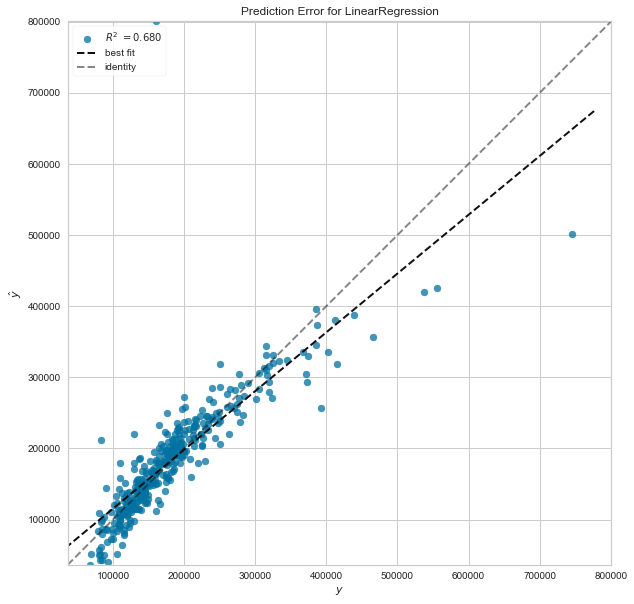

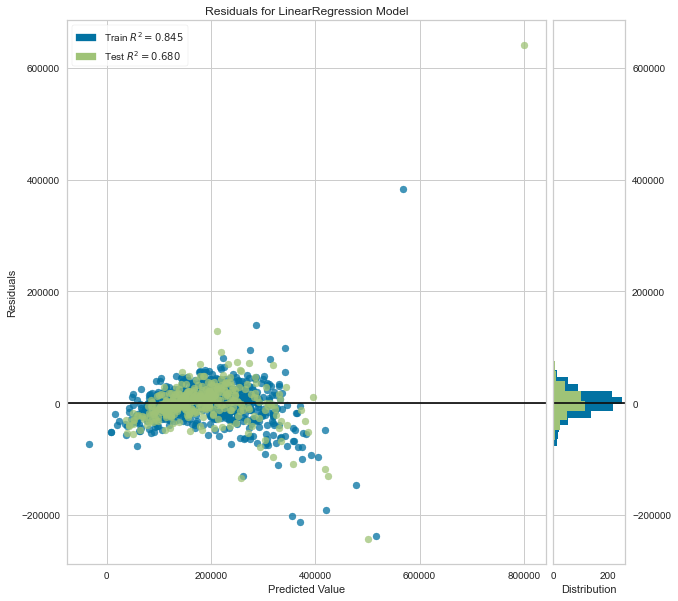

In [43]:
with mlflow.start_run(run_name='LR'): 
    mlflow.log_metrics({'R2_Score':r2_score(y_test,preds),
                        'MAE':mean_absolute_error(y_test,preds), 
                        'MSE':mean_squared_error(y_test, preds)})
    # Artifacts and Figures
    with tempfile.TemporaryDirectory() as dp:  # Save and log local dir
        joblib.dump(m, Path(dp, 'model.pkl'))
        mlflow.log_artifacts(dp)
        
        perror = pred_error(X_train,X_test,y_train,y_test)
        res = residuals(X_train,X_test,y_train,y_test)
        mlflow.log_figure(perror, 'Prediction Error.png')
        mlflow.log_figure(res, 'Residiual Error.png')

**View**
- In Terminal **mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri experiments**

# Load Best Model and Artifacts

In [16]:
def load_dict(filepath):
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [32]:
experiment_id = mlflow.get_experiment_by_name("housing").experiment_id
print(f'Experiment ID: {experiment_id}')
all_runs= mlflow.search_runs(experiment_ids=experiment_id)
all_runs

Experiment ID: 1


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.R2_Score,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,e1ae17e6eccf432b864bf53819543057,1,FINISHED,file:///C:\Users\crysi\Documents\GitHub\Data-S...,2022-09-19 19:02:15.954000+00:00,2022-09-19 19:02:16.499000+00:00,0.680138,LR,C:\Users\crysi\anaconda3\envs\ds\lib\site-pack...,crysi,LOCAL


In [39]:
best_run_id = all_runs.iloc[0]['run_id']
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path='', dst_path=dp)
    model = joblib.load(Path(dp, 'model.pkl'))